In [1]:
import os
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt

from utils import (
    COIN_DETAILS_FILE_PATH,
    TRAIN_TARGETS_PARQUET_FILE_PATH,
    COINMARKETCAP_API_KEY, 
    SAMPLE_SYMBOLS)

In [2]:
train_df = pd.read_parquet(TRAIN_TARGETS_PARQUET_FILE_PATH)

headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': COINMARKETCAP_API_KEY,
}

base_url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/'

# Function to fetch cryptocurrency info from CoinMarketCap
def get_coin_info(symbol):
    url = base_url + 'info'
    params = {'symbol': symbol}
    try:
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 400:
            print(f"Bad request for symbol: {symbol} - Skipping retry")
            return None, 400
        response.raise_for_status()
        data = response.json()
        return data, 200
    except requests.exceptions.RequestException as e:
        print(f"Request failed for symbol: {symbol} - {e}")
        return None, 0

# Function to fetch and handle rate limiting
def fetch_coin_info_with_retry(symbol, retries=2, delay=60):
    for attempt in range(retries):
        data, status_code = get_coin_info(symbol)
        
        if status_code == 400:
            # Skip retry if status code is 400
            return None
        if data is not None:
            return data
    
        print(f"Retrying {symbol} after {delay} seconds...")
        time.sleep(delay)
    return None

# Load existing data if the file exists
if os.path.exists(COIN_DETAILS_FILE_PATH):
    existing_data = pd.read_csv(COIN_DETAILS_FILE_PATH)
else:
    existing_data = pd.DataFrame(columns=['symbol', 'name'])

# Extract unique symbols from your dataset
unique_symbols = train_df['symbol'].unique()

# Identify symbols for which names are missing
existing_symbols_downloaded = existing_data[~existing_data['name'].isna() & (existing_data['name'] != '')]['symbol']
missing_symbols = set(unique_symbols) - set(existing_symbols_downloaded)

# Convert the pandas series to a set
existing_symbols_with_names_set = set(existing_symbols_downloaded)

# Print the number of elements in each set
print(f"Number of unique symbols in train_df: {len(unique_symbols)}")
print(f"Number of symbols in existing_data with data: {len(existing_symbols_with_names_set)}")
print(f"Number of missing symbols: {len(missing_symbols)}")

# # Optional: Print the actual sets for debugging
print(f"Unique symbols in train_df: {set(unique_symbols)}")
print(f"Symbols in existing_data with names: {existing_symbols_with_names_set}")
print(f"Missing symbols: {missing_symbols}")

# Loop through missing symbols and fetch their information with rate limiting
requests_made = 0
request_limit = 30
request_window = 60  # seconds

for symbol in missing_symbols:
    if requests_made >= request_limit:
        print(f"Reached {request_limit} requests, sleeping for {request_window} seconds.")
        time.sleep(request_window)
        requests_made = 0

    coin_info = fetch_coin_info_with_retry(symbol)
    requests_made += 1
    
    if coin_info and 'data' in coin_info and symbol in coin_info['data']:
        coin_data = coin_info['data'][symbol]
        coin_details = {
            'symbol': coin_data['symbol'],
            'name': coin_data['name'],
            'circulating_supply': coin_data['self_reported_circulating_supply'],
            'market_cap': coin_data['self_reported_market_cap'],
            'infinite_supply': coin_data['infinite_supply'],
            'source_code': coin_data['urls']['source_code'][0] if 'urls' in coin_data and 'source_code' in coin_data['urls'] and coin_data['urls']['source_code'] else None,
        }
    else:
        coin_details = {'symbol': symbol, 'name': None, 'circulating_supply': None}
    
    # Convert the new entry to DataFrame
    new_coin_details_df = pd.DataFrame([coin_details])

    print(f"Saving details for {coin_details}")

    # Concatenate with existing data
    updated_data = pd.concat([existing_data, new_coin_details_df], ignore_index=True)
    
    # Save the updated DataFrame to CSV incrementally
    updated_data.to_csv(COIN_DETAILS_FILE_PATH, index=False)
    
    # Update existing_data to include the newly fetched details
    existing_data = updated_data

# Display the final updated DataFrame
updated_data.head()


Number of unique symbols in train_df: 1437
Number of symbols in existing_data with data: 1435
Number of missing symbols: 2
Unique symbols in train_df: {'POOLX', 'FUSE', 'NIM', 'CTX', 'DIMO', 'GFT', 'LAZIO', 'PNT', 'SAMO', 'CRDT', 'EPIK', 'NETVR', 'KASTA', 'WILD', 'VR', 'VELO', 'VEX', 'DEC', 'SENSO', 'ACM', 'AHT', 'SOV', 'SPARTA', 'AIOZ', 'AL', 'AURY', 'HNS', 'CRE', 'PMG', 'WLD', 'KEEP', 'RSS3', 'S4F', 'ZIK', 'FITFI', 'STORJ', 'FINE', 'BAN', 'KOM', 'CRPT', 'GLM', 'OLT', 'Gomining', 'BBANK', 'MTA', 'BASE', '0xBTC', 'ARV', 'VIDYA', 'VALOR', 'METIS', 'CRV', 'RVF', 'SWASH', 'METFI', 'SFX', 'FLR', 'vETH', 'RBTC', 'AGLD', 'INJ', 'PBX', 'QOM', 'XED', 'GEOD', 'FEAR', 'JGN', 'TURBO', 'GXT', 'IDNA', 'GALA', 'EVY', 'UMA', 'LNC', 'BTR', 'AMP', 'YLD', 'TREEB', 'PLU', 'NEO', 'BTCP', 'STAKE', 'SKILL', 'JULD', 'WEST', 'BTCST', 'EQUAD', 'UOS', 'PEPE', 'SQUIDGROW', 'PDA', 'DKA', 'DPI', 'SFP', 'SHX', 'GOAL', 'APM', 'PLOT', 'AUCTION', 'PIT', 'EPX', 'OBSR', 'LINKA', 'LNR', 'LYM', 'XVG', 'STAT', 'REP', 'OP',

/var/folders/pb/5sg_h26d05sf_43qbddt42080000gn/T/ipykernel_30002/326404133.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_data = pd.concat([existing_data, new_coin_details_df], ignore_index=True)
/var/folders/pb/5sg_h26d05sf_43qbddt42080000gn/T/ipykernel_30002/326404133.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_data = pd.concat([existing_data, new_coin_details_df], ignore_index=True)


,symbol,name,keywords,circulating_supply,market_cap,infinite_supply,source_code
0,SHA,Safe Haven,Safe Haven,8.500000e+09,2.140272e+06,0.0,https://github.com/Safehaven-io
1,ZBC,Zebec,Zebec,5.088365e+09,0.000000e+00,0.0,https://github.com/Zebec-protocol/
2,ITGR,Integral,Integral dex,0.000000e+00,0.000000e+00,0.0,https://github.com/ProfessorJEY/Integral-Smart...
3,DUST,Dust Protocol,Dust Protocol,3.329782e+07,4.678819e+06,0.0,NaN
4,PEPECOIN,PepeCoin,PepeCoin,0.000000e+00,0.000000e+00,0.0,https://www.github.com/memeticofficial


In [3]:
df = pd.read_csv(COIN_DETAILS_FILE_PATH)

desired_order = ['symbol', 'name', 'keywords', 'circulating_supply', 'market_cap', 'infinite_supply', 'source_code']
df = df[desired_order]

# Drop non downloaded rows
df = df.dropna(subset=['name'])

# Convert 'infinite_supply' to numeric values
df['infinite_supply'] = df['infinite_supply'].fillna(0)
df['infinite_supply'] = df['infinite_supply'].astype(int)

df = df.fillna({
    'circulating_supply': 0,
    'market_cap': 0,
    'source_code': '',
    'name': '',
    'keywords': ''
})

df.to_csv(COIN_DETAILS_FILE_PATH, index=False)

df.head()


,symbol,name,keywords,circulating_supply,market_cap,infinite_supply,source_code
0,SHA,Safe Haven,Safe Haven,8.500000e+09,2.140272e+06,0,https://github.com/Safehaven-io
1,ZBC,Zebec,Zebec,5.088365e+09,0.000000e+00,0,https://github.com/Zebec-protocol/
2,ITGR,Integral,Integral dex,0.000000e+00,0.000000e+00,0,https://github.com/ProfessorJEY/Integral-Smart...
3,DUST,Dust Protocol,Dust Protocol,3.329782e+07,4.678819e+06,0,
4,PEPECOIN,PepeCoin,PepeCoin,0.000000e+00,0.000000e+00,0,https://www.github.com/memeticofficial


In [4]:
df.shape[0]

1435

In [5]:
# df = pd.read_csv(COIN_DETAILS_FILE_PATH)
# df = df.dropna(subset=['name'])

# df1 = pd.read_csv("../data/coin_details_1.csv")

# merged_df = pd.merge(df, df1[['symbol', 'keywords']], on='symbol', how='left')

# merged_df.head()
# merged_df.to_csv(COIN_DETAILS_FILE_PATH)

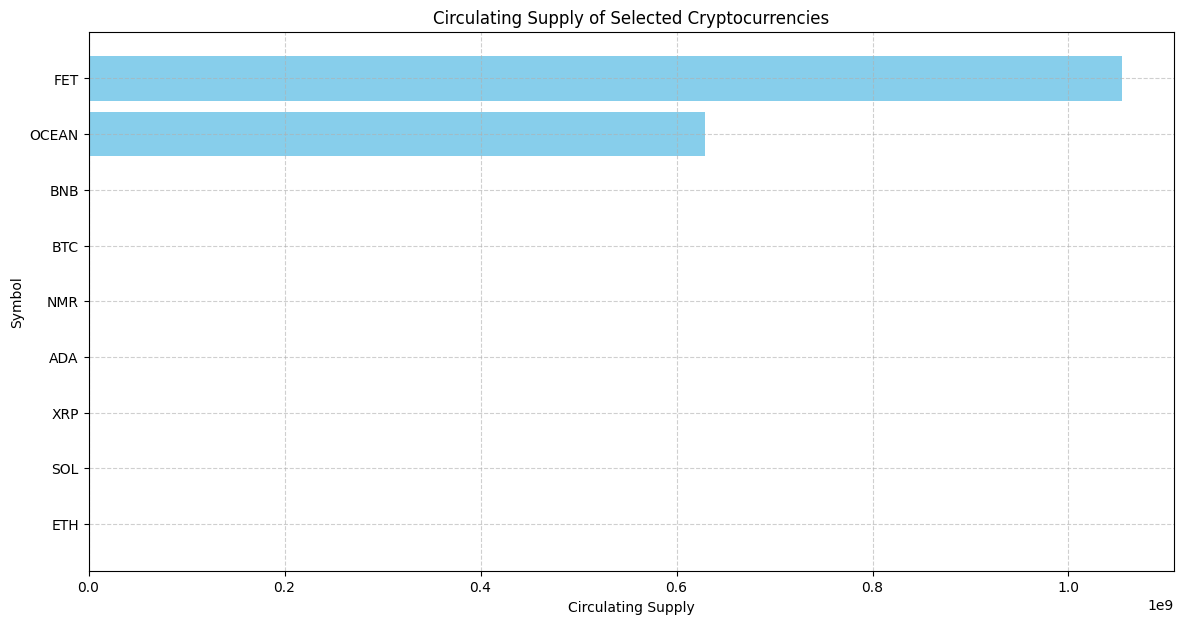

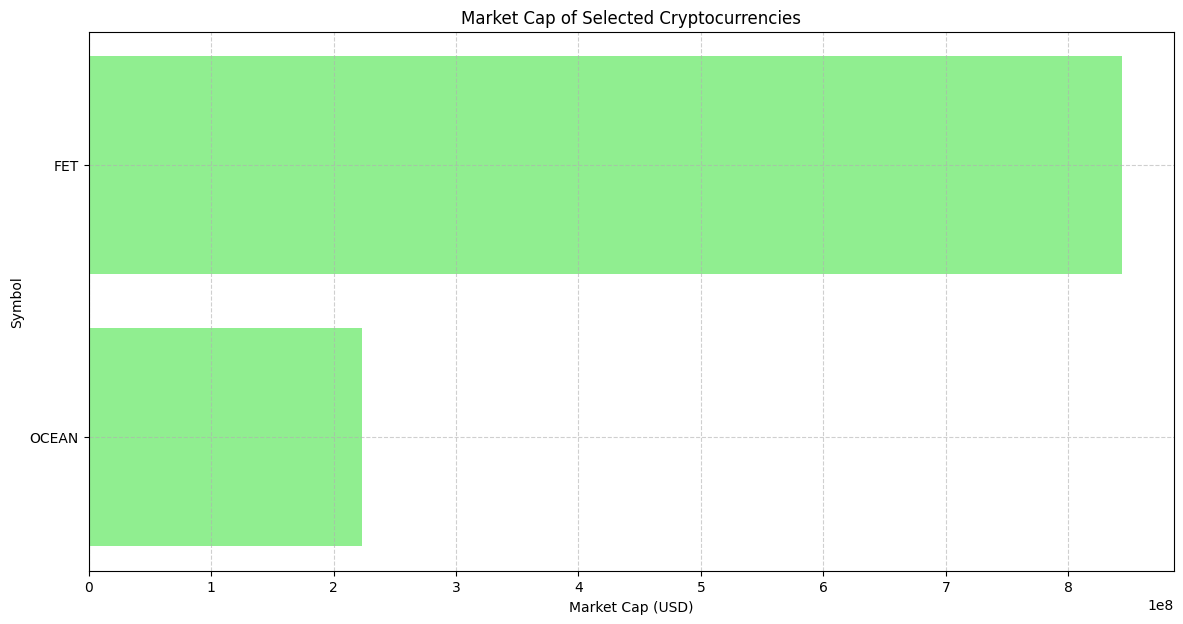

In [7]:
# Sample data
df = pd.read_csv(COIN_DETAILS_FILE_PATH)

# Filter the DataFrame for selected symbols with non-zero circulating supply
df_filtered_supply = df[(df["symbol"].isin(SAMPLE_SYMBOLS))]

# Create a bar plot for circulating supply for selected symbols
plt.figure(figsize=(14, 7))
plt.barh(df_filtered_supply["symbol"], df_filtered_supply["circulating_supply"], color="skyblue")
plt.xlabel("Circulating Supply")
plt.ylabel("Symbol")
plt.title("Circulating Supply of Selected Cryptocurrencies")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("circulating_supply_plot.png")

# Filter the DataFrame for selected symbols with non-zero market cap
df_filtered_cap = df[(df["symbol"].isin(SAMPLE_SYMBOLS)) & (df["market_cap"] > 0)]

# Create a bar plot for market cap for selected symbols
plt.figure(figsize=(14, 7))
plt.barh(df_filtered_cap["symbol"], df_filtered_cap["market_cap"], color="lightgreen")
plt.xlabel("Market Cap (USD)")
plt.ylabel("Symbol")
plt.title("Market Cap of Selected Cryptocurrencies")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("market_cap_plot.png")

plt.show()